In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
import brevis
from brevis import branches
from brevis import evaluate
import matplotlib.pyplot as plt

import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

(227, 227, 1)


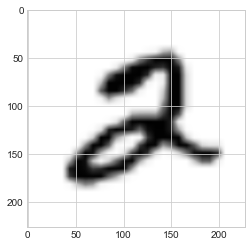

In [2]:
# train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,22500,(227,227),include_targets=False,num_outputs = 10)
# Model / data parameters
num_classes = 10
input_shape = (227, 227, 3)
def augment_images(image, label,input_size=(227,227), channel_first = False):
        # Normalize images to have a mean of 0 and standard deviation of 1
        # image = tf.image.per_image_standardization(image)
        # Resize images from 32x32 to 277x277
        image = tf.reshape(image, (28,28,1))
        # image = tf.image.grayscale_to_rgb(image, name=None)
        image = tf.image.resize(image,input_size)
        if channel_first:
            image = tf.transpose(image, [2, 0, 1])

        return image, label

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

digit_one = x_train[5]
digit_one = augment_images(digit_one,input_shape)
print(digit_one[0].shape)
# print(np.argmax(model.predict(digit_one.reshape(1,28,28))))
# print(digit_one)
from PIL import Image
# _im = Image.fromarray(np.uint8((digit_one)*255))
plt.imshow(digit_one[0])
plt.show()



In [3]:
def dataset():
    num_outputs = 10
    validation_size = 5000
    batch_size = 32
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    train_labels = tf.keras.utils.to_categorical(train_labels,num_outputs)
    test_labels = tf.keras.utils.to_categorical(test_labels,num_outputs)
    
    validation_images, validation_labels = train_images[:validation_size], train_labels[:validation_size] #get the first 5k training samples as validation set
    train_images, train_labels = train_images[validation_size:], train_labels[validation_size:] # now remove the validation set from the training set.
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    validation_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
    
    def augment_images(image, label,input_size=(227,227), channel_first = False):
        # Normalize images to have a mean of 0 and standard deviation of 1
        # image = tf.image.per_image_standardization(image)
        # Resize images from 32x32 to 277x277
        image = tf.reshape(image, (28,28,1))
        # image = tf.image.grayscale_to_rgb(image, name=None)
        image = tf.image.resize(image,input_size)
        if channel_first:
            image = tf.transpose(image, [2, 0, 1])

        return image, label



    train_ds_size = len(list(train_ds))
    test_ds_size = len(list(test_ds))
    validation_ds_size = len(list(validation_ds))

    print("trainSize {}".format(train_ds_size))
    print("testSize {}".format(test_ds_size))

    train_ds = (train_ds
                    .map(augment_images)
                    .shuffle(buffer_size=int(train_ds_size/3),seed=42,reshuffle_each_iteration=False)
                    .batch(batch_size=batch_size, drop_remainder=True))

    test_ds = (test_ds
                    # .map(augment_images)
                    #   .shuffle(buffer_size=train_ds_size)
                    .batch(batch_size=batch_size, drop_remainder=True))

    validation_ds = (validation_ds
                    # .map(augment_images)
                    #   .shuffle(buffer_size=validation_ds_size)
                    .batch(batch_size=batch_size, drop_remainder=True))

    return (train_ds, test_ds, validation_ds)

train_ds, test_ds, validation_ds = dataset()

trainSize 55000
testSize 10000


In [4]:
def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    # tf.print("alpha",alpha.shape)
    # tf.print("beta",beta.shape)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    # print("kl", kl)
    return kl


import tensorflow.python.keras.backend as K


current_epoch = K.variable(0.)
        
        
class changeAlpha(tf.keras.callbacks.Callback):
    def __init__(self):
        super(changeAlpha, self).__init__()
        self.current_epoch = current_epoch
    def on_epoch_begin(self, epoch, logs={}):

        K.set_value(self.current_epoch, epoch)
        tf.print("current epoch", K.get_value(current_epoch))
        
        
def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function




In [5]:

# inputs = keras.Input(shape=(227,227,1))
# x = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1))(inputs)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
# x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
# x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
# x = keras.layers.Flatten()(x)
# x = keras.layers.Dense(4096, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(4096, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)
# x = keras.layers.Dense(10)(x)
# # model = keras.Model(inputs=inputs, outputs=[x,branchLayer,branchLayer2], name="alexnet")
# model = keras.Model(inputs=inputs, outputs=[x], name="alexnet")
# model.save("./models/mnist_alexnet.hdf5")

In [9]:
epochs = 15

# model = keras.Sequential(
#     [
#         keras.Input(shape=input_shape),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes),
#     ]
# )


def evidence_crossentropy(annealing_rate=1, momentum=1, decay=1, global_loss=False,num_outputs=10):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        # activated_outputs =tf.keras.activations.sigmoid(softmax)
        evidence = tf.nn.softplus(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((labels-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print("A+B",(A+B).shape, tf.reduce_sum(A+B, axis=1))
        # annealing_coef = tf.minimum(1.0,tf.cast(annealing_rate,tf.float32))
#         annealing_coef = 1
        alp = E*(1-labels) + 1 
        # print("alp", alp)
        C =  annealing_rate * KL(alp,num_outputs)
        # print("c",C)
        # C = keras_kl(labels,evidence)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        # tf.print("loss",loss.shape,loss)
        pred = tf.argmax(outputs,1)
        truth = tf.argmax(labels,1)
        match = tf.reshape(tf.cast(tf.equal(pred, truth), tf.float32),(-1,1))
        return loss  + C
        # return (A + B) + C
    return  cross_entropy_evidence

# model.compile(loss=loss_wrapper(current_epoch), optimizer="adam", metrics=["accuracy"])
# model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
# model.fit(train_ds, epochs=epochs,callbacks = [changeAlpha()])

def CE(annealing_rate=1, momentum=1, decay=1, global_loss=False,num_outputs=10):
    #create a wrapper function that returns a function
    temperature = 1
    Classes = 10
    keras_kl = tf.keras.losses.KLDivergence()
    annealing_rate = annealing_rate
    momentum_rate = momentum
    decay_rate = decay
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        
        evidence = tf.nn.softplus(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
        loss = tf.keras.losses.categorical_crossentropy(labels, softmax)
        return A # + C
        # return (A + B) + C
    return  cross_entropy_evidence


In [11]:
# loss_fn = loss_wrapper(1)
model = tf.keras.models.load_model("./models/mnist_alexnet.hdf5")
model.summary()
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
model.compile(loss=evidence_crossentropy(0), optimizer="adam", metrics=["accuracy"])
model.fit(train_ds, epochs=4)

Model: "alexnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024

KeyboardInterrupt: 

In [ ]:
# loss_fn = loss_wrapper(1)
epoch = 4
model = tf.keras.models.load_model("./models/mnist_alexnet.hdf5")
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(epochs):
    print("annealing_coef:", tf.minimum(1,tf.cast(i/100,tf.float32)))
    # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.compile(loss=loss_wrapper(0), optimizer="adam", metrics=["accuracy"])
    model.fit(train_ds,epochs = 1)

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)
1718/1718 [==============================] - 115s 65ms/step - loss: 0.4947 - accuracy: 0.6007
annealing_coef: tf.Tensor(0.01, shape=(), dtype=float32)
1718/1718 [==============================] - 117s 67ms/step - loss: 0.3732 - accuracy: 0.6923
annealing_coef: tf.Tensor(0.02, shape=(), dtype=float32)
1718/1718 [==============================] - 119s 68ms/step - loss: 0.3619 - accuracy: 0.6983
annealing_coef: tf.Tensor(0.03, shape=(), dtype=float32)
1718/1718 [==============================] - 120s 69ms/step - loss: 0.3504 - accuracy: 0.7034
annealing_coef: tf.Tensor(0.04, shape=(), dtype=float32)
1718/1718 [==============================] - 121s 69ms/step - loss: 0.3630 - accuracy: 0.6942
annealing_coef: tf.Tensor(0.05, shape=(), dtype=float32)
1718/1718 [==============================] - 123s 70ms/step - loss: 0.3459 - accuracy: 0.7037
annealing_coef: tf.Tensor(0.06, shape=(), dtype=float32)
1718/1718 [===========================

In [6]:
# loss_fn = loss_wrapper(1)
epoch = 4
model = tf.keras.models.load_model("./models/mnist_alexnet.hdf5")
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(epochs):
    print("annealing_coef:", tf.minimum(1,tf.cast(i/100,tf.float32)))
    # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.fit(train_ds,epochs = 1)

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)
1718/1718 [==============================] - 116s 65ms/step - loss: 0.4947 - accuracy: 0.6007
annealing_coef: tf.Tensor(0.01, shape=(), dtype=float32)
1718/1718 [==============================] - 117s 67ms/step - loss: 0.7592 - accuracy: 0.4014
annealing_coef: tf.Tensor(0.02, shape=(), dtype=float32)
1718/1718 [==============================] - 117s 67ms/step - loss: 0.9032 - accuracy: 0.2008
annealing_coef: tf.Tensor(0.03, shape=(), dtype=float32)
1718/1718 [==============================] - 116s 66ms/step - loss: 0.9808 - accuracy: 0.0975
annealing_coef: tf.Tensor(0.04, shape=(), dtype=float32)
 167/1718 [=>............................] - ETA: 1:44 - loss: 0.9818 - accuracy: 0.0969

KeyboardInterrupt: 

In [11]:
# loss_fn = loss_wrapper(1)
model = tf.keras.models.load_model("./models/mnist_alexnet.hdf5")
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(epochs):
    print("annealing_coef:", tf.minimum(1,tf.cast(i/100,tf.float32)))
    # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.fit(train_ds,epochs = 1)

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)
1718/1718 [==============================] - 122s 69ms/step - loss: 0.3074 - accuracy: 0.7570
annealing_coef: tf.Tensor(0.1, shape=(), dtype=float32)
1718/1718 [==============================] - 125s 71ms/step - loss: 0.7559 - accuracy: 0.4441
annealing_coef: tf.Tensor(0.2, shape=(), dtype=float32)
1718/1718 [==============================] - 124s 71ms/step - loss: 0.9818 - accuracy: 0.1006
annealing_coef: tf.Tensor(0.3, shape=(), dtype=float32)
1718/1718 [==============================] - 125s 72ms/step - loss: 0.9818 - accuracy: 0.0990
annealing_coef: tf.Tensor(0.4, shape=(), dtype=float32)
1718/1718 [==============================] - 127s 72ms/step - loss: 0.9818 - accuracy: 0.0990
annealing_coef: tf.Tensor(0.5, shape=(), dtype=float32)
1718/1718 [==============================] - 128s 73ms/step - loss: 0.9818 - accuracy: 0.0990
annealing_coef: tf.Tensor(0.6, shape=(), dtype=float32)
 454/1718 [======>.......................] -

KeyboardInterrupt: 

In [6]:
# loss_fn = loss_wrapper(1)
model.compile(loss=evidence_crossentropy(0), optimizer="adam", metrics=["accuracy"])
model.fit(train_ds, epochs=15)

Epoch 1/15
1406/1406 [==============================] - 98s 52ms/step - loss: 2.4967 - accuracy: 0.2871
Epoch 2/15
1406/1406 [==============================] - 92s 55ms/step - loss: 1.7438 - accuracy: 0.3845
Epoch 3/15
1406/1406 [==============================] - 87s 54ms/step - loss: 1.5854 - accuracy: 0.4409
Epoch 4/15
1406/1406 [==============================] - 84s 53ms/step - loss: 1.3875 - accuracy: 0.5227
Epoch 5/15
1406/1406 [==============================] - 84s 53ms/step - loss: 1.1842 - accuracy: 0.5959
Epoch 6/15
1406/1406 [==============================] - 80s 50ms/step - loss: 1.0353 - accuracy: 0.6465
Epoch 7/15
1406/1406 [==============================] - 82s 52ms/step - loss: 0.9170 - accuracy: 0.6903
Epoch 8/15
1406/1406 [==============================] - 82s 51ms/step - loss: 0.8225 - accuracy: 0.7219
Epoch 9/15
1406/1406 [==============================] - 80s 51ms/step - loss: 0.7450 - accuracy: 0.7498
Epoch 10/15
1406/1406 [==============================] - 82s 52m

KeyboardInterrupt: 

In [75]:

#entropy version
model = keras.Sequential(
    [
        keras.Input(shape=(227,227,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes),
    ]
)


def loss_wrapper(annealing_coef):
    def custom_loss_function(p, logits):
    #     squared_difference = tf.square(y_true - y_pred)
    #     return tf.reduce_mean(squared_difference, axis=-1)
    #     alpha = alpha + 1
        evidence = tf.nn.relu(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 

        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        return (A + B) + C
    return custom_loss_function



#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
for i in range(epochs):
    print("annealing_coef:", tf.minimum(1,tf.cast(i/10,tf.float32)))
    # model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.compile(loss=loss_wrapper(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    model.fit(train_ds,epochs = 1)
    

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)
 606/1718 [=========>....................] - ETA: 52s - loss: 0.9073 - accuracy: 0.2366

KeyboardInterrupt: 

In [72]:

inputs = keras.Input(shape=(227,227,1))
x = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1))(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(10)(x)
# model = keras.Model(inputs=inputs, outputs=[x,branchLayer,branchLayer2], name="alexnet")
model = keras.Model(inputs=inputs, outputs=[x], name="alexnet")

#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
opt_weights = None
for i in range(4):
    annealing = tf.minimum(1,tf.cast(i/10,tf.float32))
    print("annealing_coef:", annealing)
    # model.compile(loss=evidence_crossentropy(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    Adam = tf.keras.optimizers.Adam()

    model.compile(loss= loss_wrapper(annealing), optimizer=Adam, metrics=["accuracy"])
    # if opt_weights is not None: 
        # Adam.set_weights(opt_weights)
    model.fit(train_ds,epochs = 1)
    # opt_weights = Adam.get_weights()
    

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)
1718/1718 [==============================] - 73s 41ms/step - loss: 0.3078 - accuracy: 0.7627
annealing_coef: tf.Tensor(0.1, shape=(), dtype=float32)
1718/1718 [==============================] - 76s 43ms/step - loss: 0.8282 - accuracy: 0.3663
annealing_coef: tf.Tensor(0.2, shape=(), dtype=float32)
1718/1718 [==============================] - 78s 42ms/step - loss: 0.9655 - accuracy: 0.1178
annealing_coef: tf.Tensor(0.3, shape=(), dtype=float32)
1718/1718 [==============================] - 74s 42ms/step - loss: 0.9818 - accuracy: 0.0968


In [71]:

inputs = keras.Input(shape=(227,227,3))
x = keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3))(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(10)(x)
# model = keras.Model(inputs=inputs, outputs=[x,branchLayer,branchLayer2], name="alexnet")
model = keras.Model(inputs=inputs, outputs=[x], name="alexnet")

#example annealing works that by the first 10 epochs the KL will reach coef of 1. so in a epoch based approach, they increase by 0.1 each time.
opt_weights = None
for i in range(4):
    annealing = tf.minimum(1,tf.cast(i/10,tf.float32))
    print("annealing_coef:", annealing)
    # model.compile(loss=evidence_crossentropy(tf.minimum(1,tf.cast(i/10,tf.float32))), optimizer="adam", metrics=["accuracy"])
    Adam = tf.keras.optimizers.Adam()

    model.compile(loss= loss_wrapper(annealing), optimizer=Adam, metrics=["accuracy"])
    # if opt_weights is not None: 
        # Adam.set_weights(opt_weights)
    model.fit(train_ds,epochs = 1)
    # opt_weights = Adam.get_weights()
    
    

annealing_coef: tf.Tensor(0.0, shape=(), dtype=float32)


ValueError: in user code:

    File "C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Sanity\AppData\Local\conda\conda\envs\py36\lib\site-packages\keras\engine\input_spec.py", line 249, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Exception encountered when calling layer "alexnet" (type Functional).
    
    Input 0 of layer "conv2d_20" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (32, 227, 227, 1)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(32, 227, 227, 1), dtype=float32)
      • training=True
      • mask=None


1


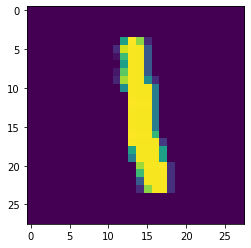

In [123]:
import matplotlib.pyplot as plt
digit_one = x_train[6]

print(np.argmax(model.predict(digit_one.reshape(1,28,28))))
plt.imshow(digit_one.reshape(28,28)) 
plt.show()

In [69]:
def rotate_img_crossevidence(model):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    # digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.001
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one[0], tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(227,227))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,227,227)))
    #     print(_pred)
        # evidence = tf.nn.relu(_pred)
        evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1


        # evidence = tf.nn.relu(_pred)
        # alpha = evidence + 1

        u = tf.reduce_sum(evidence, axis=1, keepdims=True) #uncertainty

        # prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
        print("prob", evidence)
        print("u", u.numpy(), "prob",tf.reduce_sum(evidence).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += evidence.numpy().astype("float") >= threshold
    #     print("scores",scores)
        lp.append(evidence[0])
        print(u.numpy())
        pred.append(pred)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    print("labels",labels)
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    for j in range(len(labels)):
        print(labels[j])
        print(lp)
        y =[]
        for i in range(len(lp)):
            y.append(lp[i][j])


        plt.plot(ldeg,y,marker=marker[j])



    labels += ['Entropy']
    plt.plot(ldeg,uncert,marker='<',ls='--',c='red',zorder=0)

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Predicted Probability')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

prob tf.Tensor(
[[1.95369101e+00 5.46641126e-02 3.55647545e+01 2.31667909e-05
  1.18398695e+01 3.84812639e-03 3.03567505e+00 2.12723994e+00
  6.83174953e-02 7.15787988e-03]], shape=(1, 10), dtype=float32)
u [[54.65524]] prob 54.65524
[[54.65524]]
prob tf.Tensor(
[[1.18737400e+00 3.60261500e-02 2.62294979e+01 1.92609301e-03
  1.09288540e+01 3.32423635e-02 2.38971281e+00 1.56533957e+00
  1.01419187e+00 1.21864595e-01]], shape=(1, 10), dtype=float32)
u [[43.508026]] prob 43.508026
[[43.508026]]
prob tf.Tensor(
[[0.8350009  0.22129232 9.198687   0.2307858  4.023953   0.29304078
  1.3070235  1.0822307  1.519954   0.5009298 ]], shape=(1, 10), dtype=float32)
u [[19.212896]] prob 19.212896
[[19.212896]]
prob tf.Tensor(
[[0.4654535  0.37165084 0.60903275 1.0059757  0.55827904 0.79792756
  0.5005282  0.6138263  1.365348   1.1533364 ]], shape=(1, 10), dtype=float32)
u [[7.441358]] prob 7.441358
[[7.441358]]
prob tf.Tensor(
[[0.13847306 0.16924931 0.8428209  0.9675679  0.14049084 0.845435
  1.2477

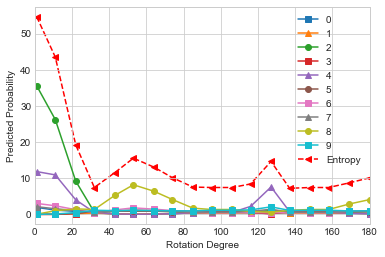

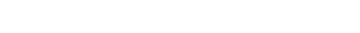

[54.65524, 43.508026, 19.212896, 7.441358, 11.555632, 15.553953, 13.0816345, 10.147026, 7.565924, 7.441358, 7.441358, 8.422855, 14.640577, 7.2245064, 7.441358, 7.441358, 8.718446, 10.123716]


In [70]:
rotate_img_crossevidence(model)

prob tf.Tensor(
[[6.5535186e-13 1.8844068e-01 2.7934789e-07 1.1621394e-08 5.5195746e-09
  2.8452870e-11 4.5765403e-10 7.9887830e-09 5.2179043e-06 1.9766713e-10]], shape=(1, 10), dtype=float32)
u [[0.98150396]] prob 1.0
[[0.98150396]]
prob tf.Tensor(
[[3.61930054e-24 5.23236622e-07 1.17731085e-11 3.07065673e-14
  5.92468445e-18 6.72315817e-18 3.69096184e-19 2.82275813e-14
  1.58854082e-12 8.14536661e-17]], shape=(1, 10), dtype=float32)
u [[1.]] prob 1.0000001
[[1.]]
prob tf.Tensor(
[[1.0103113e-21 6.2338011e-05 2.7430216e-11 2.7323128e-14 1.9854088e-16
  1.5509566e-14 1.6467396e-17 5.1948827e-16 7.6999594e-13 1.6310468e-18]], shape=(1, 10), dtype=float32)
u [[0.9999937]] prob 0.9999999
[[0.9999937]]
prob tf.Tensor(
[[1.66884962e-15 1.13744164e-07 3.11397501e-12 1.51806831e-11
  7.54755850e-13 8.48355674e-12 1.99233008e-14 5.89834171e-12
  5.62279390e-13 5.99075434e-17]], shape=(1, 10), dtype=float32)
u [[1.]] prob 1.0000001
[[1.]]
prob tf.Tensor(
[[2.2831786e-16 5.1840771e-11 3.6141695e

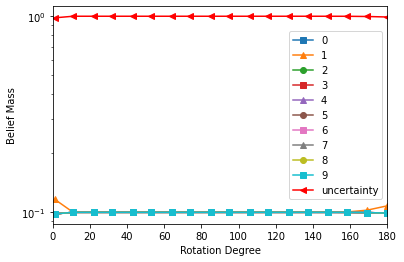

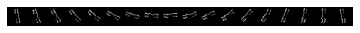

[0.98150396, 1.0, 0.9999937, 1.0, 1.0, 1.0, 0.9999943, 0.999997, 0.99999094, 0.9999927, 1.0, 1.0, 0.99999964, 0.99997246, 0.9998981, 0.999571, 0.9971512, 0.9911228]


In [124]:
import tensorflow_addons as tfa
linspace = np.linspace(1,180,num=18)
digit_one = x_train[6]
import matplotlib.pyplot as plt
Mdeg = 180 
Ndeg = int(Mdeg/10)+1
K = 10
# print(linspace)
pred = []
uncert = []
label = []
answer = []
ldeg = []
lp = []
lu=[]
scores = np.zeros((1,K))
threshold = 0.001
Results = pd.DataFrame()
rimgs = []
K=10
from PIL import Image

for i in linspace:
    i = int(i)
    radians = i* np.pi/180
    # print(radians)
    rotate = tfa.image.rotate(digit_one, tf.constant(radians))
    rimg = rotate
    rimgs.append(rimg.numpy().reshape(28,28))
#     rimgs.append(rotate)
    _pred=model.predict(tf.reshape(rotate,(1,28,28)))
#     print(_pred)
    # evidence = tf.nn.relu(_pred)
    evidence = tf.nn.softplus(_pred)
    # alpha = evidence + 1
    
    
    # evidence = tf.nn.relu(_pred)
    alpha = evidence + 1

    u = K / tf.reduce_sum(alpha, axis=1, keepdims=True) #uncertainty

    prob = alpha/tf.reduce_sum(alpha, 1, keepdims=True) 
    print("prob", evidence)
    print("u", u.numpy(), "prob",tf.reduce_sum(prob).numpy())
    # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
    # prob = evidence/tf.reduce_sum(evidence, 1) 
#     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
    scores += prob.numpy().astype("float") >= threshold
#     print("scores",scores)
    lp.append(prob[0])
    print(u.numpy())
    pred.append(prob)
    uncert.append(u.numpy().mean())
    label.append(1)
    answer.append(np.argmax(_pred))
    ldeg.append(i)
labels = np.arange(10)[scores[0].astype(bool)]
# print("labels",labels)
lp = np.array(lp)[:,labels]
# c = ['black','blue','red','brown','purple','cyan']
marker = ['s','^','o']*4
labels = labels.tolist()
# print("lp",lp)

print(labels)
for j in range(len(labels)):
    # print(lp[:,j], answer[j])
    
    
    plt.plot(ldeg,lp[:,j],marker=marker[j])
    


labels += ['uncertainty']
plt.plot(ldeg,uncert,marker='<',c='red')

plt.legend(labels)
 
plt.xlim([0,Mdeg])  
plt.xlabel('Rotation Degree')
plt.ylabel('Belief Mass')
plt.yscale("log")
plt.show()

img = Image.new('L', (28*len(rimgs), 28))
x_offset =0
for im in rimgs:
#     print(im)
    _im = Image.fromarray(np.uint8((im)*255))
    img.paste(_im,(x_offset,0))
    x_offset += _im.size[0]
    
plt.figure(figsize=[6.2,100])
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show()
#     print(pred, np.argmax(pred))
#     _ = plt.imshow(rotate)
#     plt.show()
print(uncert)

In [102]:
def rotate_img_entropy():
    def calcEntropy_Tensors2(y_hat):
        #entropy is the sum of y * log(y) for all possible labels.
        #doesn't deal with cases of log(0)
        val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        return -sumEntropies

    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.2
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        prob = _pred
        # evidence = tf.nn.relu(_pred)
        # evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1
        
        u = calcEntropy_Tensors2(prob)
        print("prob", _pred)
        print("u", tf.reduce_sum(u).numpy(), "prob",tf.reduce_sum(prob).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += _pred.astype("float") >= threshold
    #     print("scores",scores)
        lp.append(prob[0])
        print(u.numpy())
        pred.append(prob)
        uncert.append(u.numpy().mean())
        label.append(1)
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    # print("labels",labels)
    lp = np.array(lp)[:,labels]
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    print(labels)
    for j in range(len(labels)):
        print(lp[:,j], answer[j])


        plt.plot(ldeg,lp[:,j],marker=marker[j])



    labels += ['Entropy']
    plt.plot(ldeg,uncert,marker='<',c='red')

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Belief Mass / Entropy Score')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

In [161]:
def rotate_img_crossentropy(model):
    import tensorflow_addons as tfa
    linspace = np.linspace(1,180,num=18)
    digit_one = x_train[6]
    import matplotlib.pyplot as plt
    Mdeg = 180 
    Ndeg = int(Mdeg/10)+1
    K = 10
    # print(linspace)
    pred = []
    uncert = []
    label = []
    answer = []
    ldeg = []
    lp = []
    lu=[]
    scores = np.zeros((1,K))
    threshold = 0.2
    Results = pd.DataFrame()
    rimgs = []
    K=10
    from PIL import Image

    for i in linspace:
        i = int(i)
        radians = i* np.pi/180
        # print(radians)
        rotate = tfa.image.rotate(digit_one, tf.constant(radians))
        rimg = rotate
        rimgs.append(rimg.numpy().reshape(28,28))
    #     rimgs.append(rotate)
        _pred=model.predict(tf.reshape(rotate,(1,28,28)))
        # evidence = tf.nn.relu(_pred)
        evidence = tf.nn.softplus(_pred)
        # alpha = evidence + 1
        prob = np.amax(evidence)
        # u = prob
        u = tf.reduce_sum(evidence, axis=1, keepdims=True).numpy() #uncertainty
        # u = np.reduce_sum(evidence)
        print("prob", evidence)
        print("u", tf.reduce_sum(u).numpy(), "prob",tf.reduce_sum(evidence).numpy())
        # u = K / tf.reduce_sum(alpha, axis=1) #uncertainty
        # prob = evidence/tf.reduce_sum(evidence, 1) 
    #     print("pred",prob, "label?",np.argmax(prob), "uncert", u)
        scores += prob.astype("float") 
    #     print("scores",scores)
    
    
    
        lp.append(evidence[0])
        pred.append(prob)
        uncert.append(u.mean())
        answer.append(np.argmax(_pred))
        ldeg.append(i)
    labels = np.arange(10)[scores[0].astype(bool)]
    print("labels",labels)
    # c = ['black','blue','red','brown','purple','cyan']
    marker = ['s','^','o']*4
    labels = labels.tolist()
    # print("lp",lp)
    plt.yscale('log')
    
    for j in range(len(labels)):
        print(labels[j])
        # print(lp)
        y =[]
        for i in range(len(lp)):
            y.append(lp[i][j])


        plt.plot(ldeg,y,marker=marker[j])



    labels += ['Certanity']
    plt.plot(ldeg,uncert,marker='<',ls='--',c='red',zorder=0)

    plt.legend(labels)

    plt.xlim([0,Mdeg])  
    plt.xlabel('Rotation Degree')
    plt.ylabel('Predicted Probability')
    plt.show()

    img = Image.new('L', (28*len(rimgs), 28))
    x_offset =0
    for im in rimgs:
    #     print(im)
        _im = Image.fromarray(np.uint8((im)*255))
        img.paste(_im,(x_offset,0))
        x_offset += _im.size[0]

    plt.figure(figsize=[6.2,100])
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #     print(pred, np.argmax(pred))
    #     _ = plt.imshow(rotate)
    #     plt.show()
    print(uncert)

prob tf.Tensor(
[[1.0964890e-08 1.6847100e+00 1.8928564e-06 1.7925127e-07 1.0670565e-05
  1.3333648e-07 1.7490745e-06 7.6637001e-08 4.9270166e-05 8.1341007e-08]], shape=(1, 10), dtype=float32)
u 1.684774 prob 1.684774
prob tf.Tensor(
[[1.7824584e-11 1.1883412e-01 1.5200213e-05 1.5144473e-06 4.2996984e-09
  1.9316868e-08 1.9449025e-09 4.2931267e-09 2.6531627e-05 3.0361946e-08]], shape=(1, 10), dtype=float32)
u 0.118877426 prob 0.118877426
prob tf.Tensor(
[[1.36075247e-13 1.04371775e-02 9.44117801e-06 4.49078152e-09
  3.29475256e-08 6.18469675e-09 1.22163451e-11 2.27892749e-09
  3.26600897e-08 1.74050375e-11]], shape=(1, 10), dtype=float32)
u 0.010446697 prob 0.010446697
prob tf.Tensor(
[[4.16907963e-13 2.50979941e-02 1.35669552e-06 1.01298845e-08
  2.57853173e-07 1.42367573e-09 3.64997637e-13 1.56718940e-07
  1.30392586e-10 1.41429099e-11]], shape=(1, 10), dtype=float32)
u 0.025099777 prob 0.025099777
prob tf.Tensor(
[[2.4253839e-12 4.2358489e-04 2.6399945e-07 1.8646899e-07 1.4848588e-1

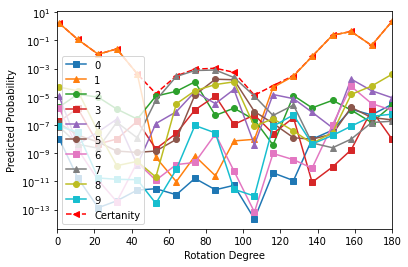

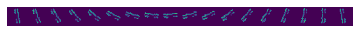

[1.684774, 0.118877426, 0.010446697, 0.025099777, 0.00042404947, 1.709822e-05, 0.00030606764, 0.00091905124, 0.0010624992, 0.00054995023, 1.3065878e-05, 6.1701656e-05, 0.0003175327, 0.0073545645, 0.23709308, 0.43235517, 0.044037566, 2.30327]


In [163]:
rotate_img_crossentropy(model2)